In [1]:
import pandas as pd
import numpy as np
import skopt
import gc
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.metrics import mean_squared_error as mse
from skopt import gp_minimize
import lightgbm as lgb
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence,plot_objective,plot_evaluations

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../input/cmsdata/CMS_trigger.csv').drop(columns=['Unnamed: 0'])
df['No. of hits'] = df[['Mask_'+str(i) for i in range(12)]].sum(axis = 1)
df = df[df['No. of hits']>3].reset_index(drop=True)
df['1/pT'] = df['q/pt'].abs()
df = df.sample(frac = 0.1).reset_index(drop=True)
df = df.fillna(-100)

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df = reduce_mem_usage(df)

Memory usage after optimization is: 53.82 MB
Decreased by 75.0%


In [5]:
space  = [Real(0.01, 1, name='learning_rate', prior='log-uniform'),
          Real(0.01, 10, name='lambda_l1', prior='log-uniform'),
          Real(0.01, 10, name='lambda_l2', prior='log-uniform'),
          Integer(5, 50, name='max_depth'),
          Integer(50, 500, name='min_child_samples'),
          Real(0.6, 0.95, name='feature_fraction'),
          Real(0.6, 0.95, name='bagging_fraction'),
          Integer(10, 100, name='early_stopping'),
         ]

In [6]:
train_x = df.iloc[:int(0.8*len(df))].drop(columns = ['1/pT','q/pt','PhiAngle', 'EtaAngle'])
train_y = df['1/pT'].iloc[:int(0.8*len(df))]
valid_x = df.iloc[int(0.8*len(df)):int(0.9*len(df))].drop(columns = ['1/pT','q/pt','PhiAngle', 'EtaAngle'])
valid_y = df['1/pT'].iloc[int(0.8*len(df)):int(0.9*len(df))]
test_x = df.iloc[int(0.9*len(df)):].drop(columns = ['1/pT','q/pt','PhiAngle', 'EtaAngle'])
test_y = df['1/pT'].iloc[int(0.9*len(df)):]

In [7]:
def objective(values):
    
    lgb_dataset = lgb.Dataset(train_x.values, label=train_y)
    lgb_valid_dataset = lgb.Dataset(valid_x.values, label=valid_y)
    
    lgb_r_params = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': values[0],
    'lambda_l1': values[1],
    'lambda_l2': values[2],
    'max_depth': values[3],
    'min_child_samples': values[4],
    'feature_fraction': values[5],
    'bagging_fraction': values[6],
    'n_estimators' : 1000}
    
    gbc = lgb.train(lgb_r_params, lgb_dataset, valid_names=["train", "valid"], 
                    valid_sets=[lgb_dataset, lgb_valid_dataset], 
                    early_stopping_rounds=values[7], verbose_eval=False)
    
    valid_preds = gbc.predict(valid_x.values, num_iteration=gbc.best_iteration)
    valid_mse =  mse(valid_preds, valid_y)
    
    test_preds = gbc.predict(test_x.values, num_iteration=gbc.best_iteration)
    test_mse =  mse(test_preds, test_y)
    
    print('Best Iteration - ',gbc.best_iteration, '  |  ','Valid MSE - ',valid_mse, '  |  ', 'Test MSE - ', test_mse)
    print()
    gc.collect()
    
    return test_mse

In [8]:
res_gp = gp_minimize(objective, space, n_calls=150,
                     random_state=0,n_random_starts=10)

"Best score=%.4f" % res_gp.fun

Best Iteration -  966   |   Valid MSE -  0.0018796131796049676   |   Test MSE -  0.0018469106635779187

Best Iteration -  1000   |   Valid MSE -  0.0019286587377731032   |   Test MSE -  0.0019010736118845106

Best Iteration -  855   |   Valid MSE -  0.0019938550269352315   |   Test MSE -  0.0019585890075642693

Best Iteration -  1000   |   Valid MSE -  0.0017663365965839093   |   Test MSE -  0.0017467542799816742

Best Iteration -  1000   |   Valid MSE -  0.00195759769792619   |   Test MSE -  0.0019282433145472227

Best Iteration -  447   |   Valid MSE -  0.0019683910091932598   |   Test MSE -  0.0019242724335093143

Best Iteration -  1000   |   Valid MSE -  0.0018112946745625846   |   Test MSE -  0.001792509702351915

Best Iteration -  1000   |   Valid MSE -  0.0018067563409951562   |   Test MSE -  0.0017787732092890813

Best Iteration -  1000   |   Valid MSE -  0.001826580613998523   |   Test MSE -  0.0017951725139680266

Best Iteration -  1000   |   Valid MSE -  0.002058878832317163

'Best score=0.0017'

In [9]:
print("Best parameters:")
print("- learning_rate=",res_gp.x[0])
print("- lambda_l1=",res_gp.x[1])
print("- lambda_l2=",res_gp.x[2])
print("- max_depth=",res_gp.x[3])
print("- min_child_samples=",res_gp.x[4])
print("- feature_fraction=",res_gp.x[5])
print("- bagging_fraction=",res_gp.x[6])
print("- early_stopping=",res_gp.x[7])

Best parameters:
- learning_rate= 0.27622648017994983
- lambda_l1= 0.5572619319129042
- lambda_l2= 0.4093734644841744
- max_depth= 39
- min_child_samples= 98
- feature_fraction= 0.7657601467713301
- bagging_fraction= 0.6652163201643659
- early_stopping= 76


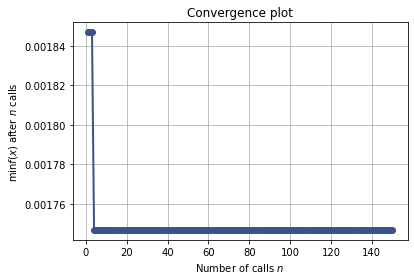

In [10]:
plot_convergence(res_gp)
plt.show()

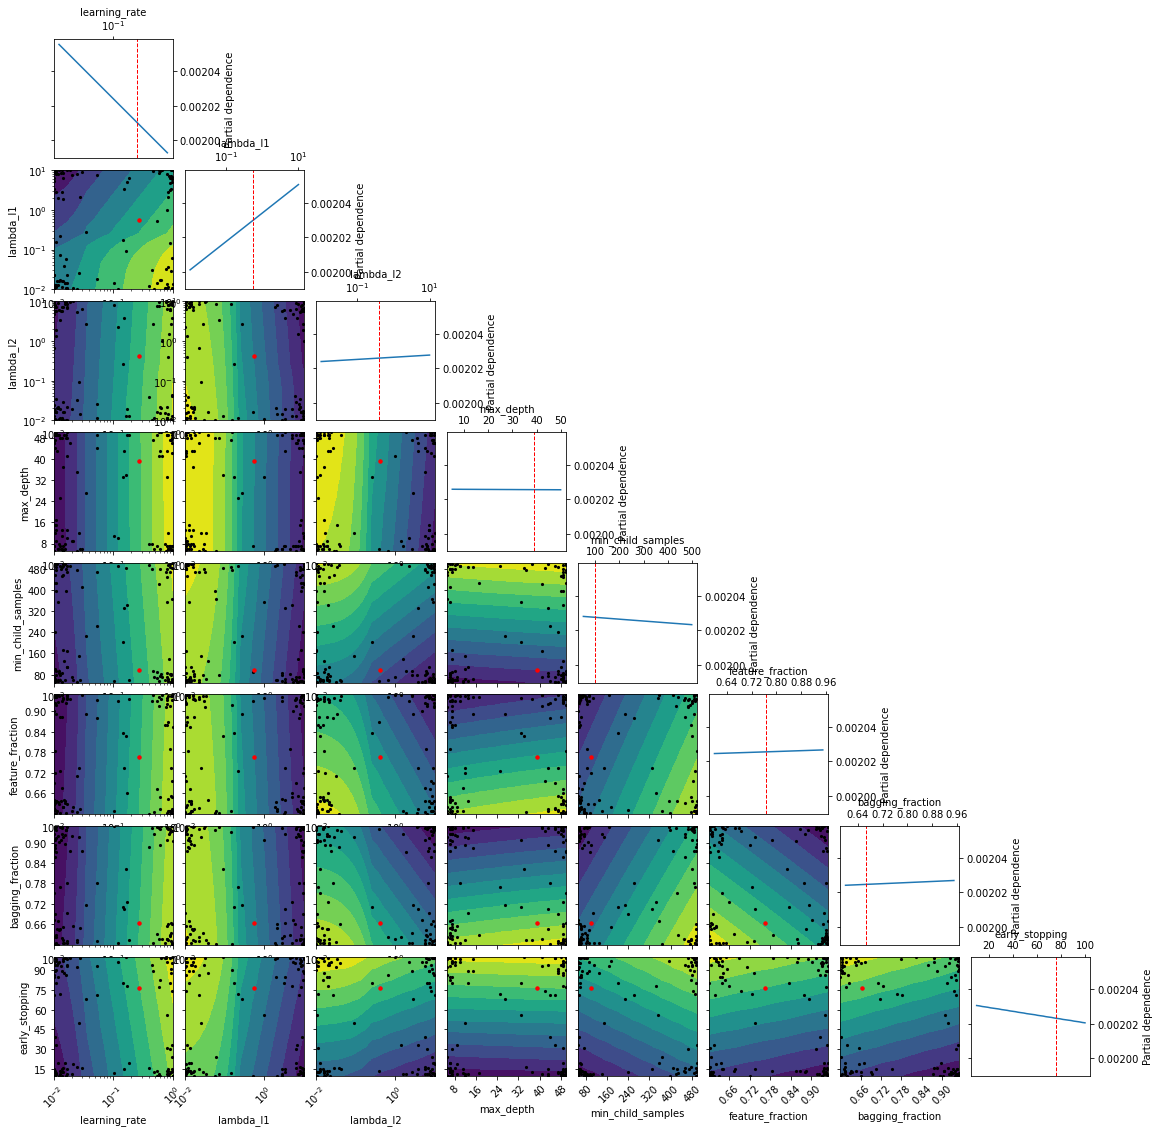

In [11]:
plot_objective(res_gp)
plt.show()

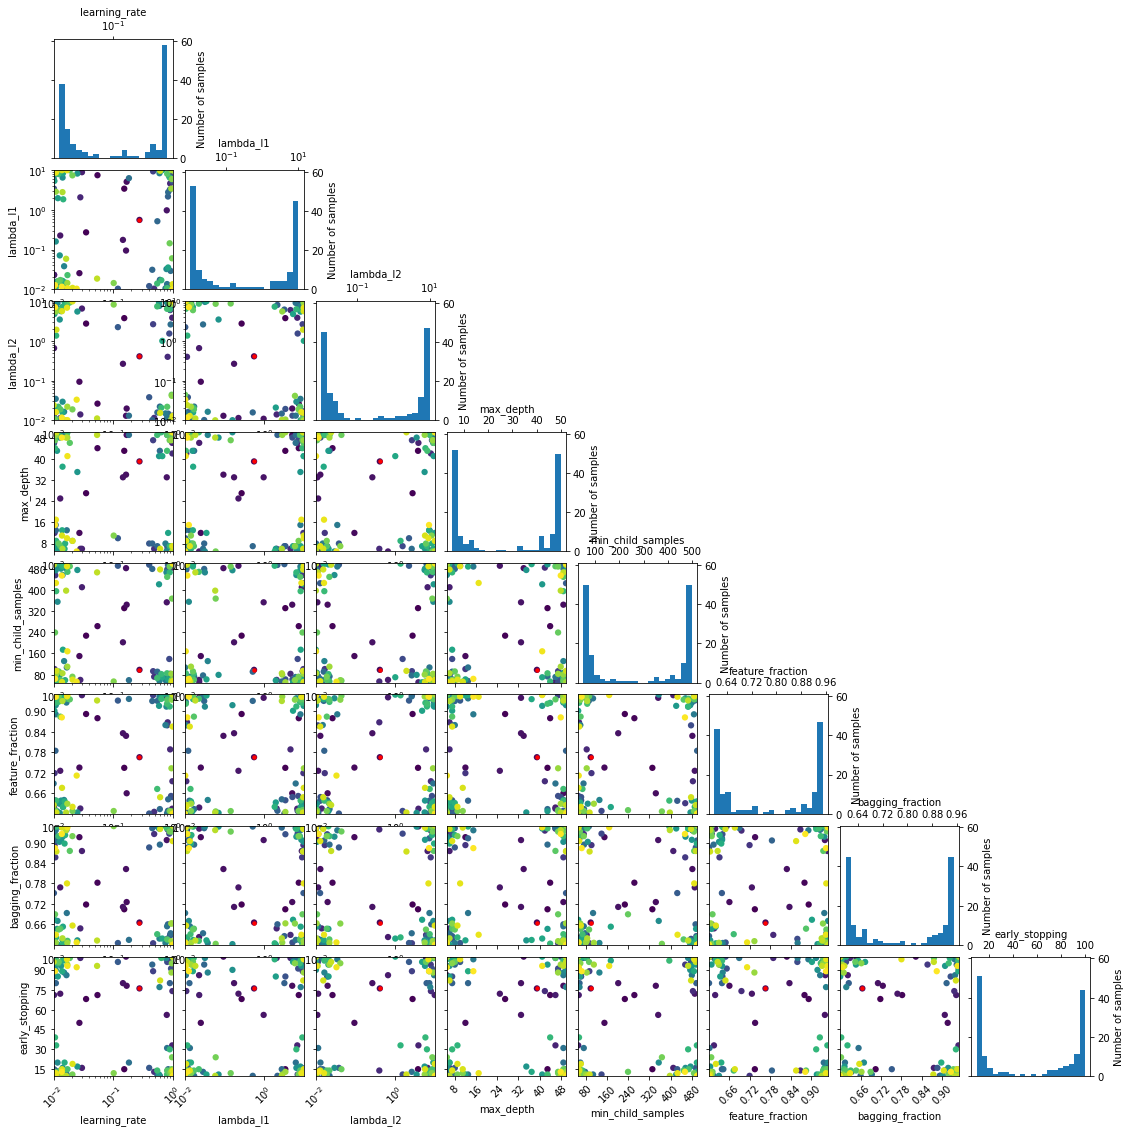

In [12]:
plot_evaluations(res_gp)
plt.show()